In [17]:
import pandas as pd
import re
import os
import glob
import snapatac2 as snap

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utils

In [19]:
method = 'wilcoxon'

In [20]:
def merge_region(region='PFC',condition="MC",folder='/data2st1/junyi/output/atac0416/dar/region_nt/',method='wilcoxon',blacklist=['Doublet','NN']):
    df_result = pd.DataFrame()
    files = glob.glob(f'{folder}/{region}*{condition}_{method}.csv')
    for file in files:
        if any([file.find(black) > -1 for black in blacklist]):
            continue
        df_dar = pd.read_csv(file,index_col=0)

        ctname = file.split('/')[-1].replace('.csv', '')
        ctname = "_".join(ctname.split('_')[1:-2])
        if len(df_dar) == 0:
            continue
        df_dar['ctname'] = ctname
        df_result = pd.concat([df_result, df_dar], axis=0, ignore_index=True)
    df_result['region'] = region
    df_result['condition'] = condition
    return df_result


In [21]:
df_PFC_MC = merge_region(region='PFC',condition="MC",method=method)
df_PFC_MW = merge_region(region='PFC',condition="MW", method=method)
df_HIP_MC = merge_region(region='HIP',condition="MC",method=method)
df_HIP_MW = merge_region(region='HIP',condition="MW", method=method)
df_AMY_MC = merge_region(region='AMY',condition="MC",method=method)
df_AMY_MW = merge_region(region='AMY',condition="MW", method=method)
df_DAR_ALL = pd.concat([df_PFC_MC, df_PFC_MW, df_HIP_MC, df_HIP_MW, df_AMY_MC, df_AMY_MW], axis=0, ignore_index=True)

In [22]:
df_DAR_ALL

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,ctname,region,condition
0,chr2:98666917-98667418,23.533844,0.900414,1.837545e-122,2.519275e-116,0.957454,0.882398,PFC_GABA,PFC,MC
1,chr2:98662045-98662546,19.915870,0.912399,2.964556e-88,2.032203e-82,0.796225,0.644653,PFC_GABA,PFC,MC
2,chr2:98666414-98666915,18.153790,0.749082,1.198400e-73,5.476689e-68,0.869162,0.760224,PFC_GABA,PFC,MC
3,chr9:35305176-35305677,13.207377,0.778344,7.954764e-40,2.726495e-34,0.575816,0.446279,PFC_GABA,PFC,MC
4,chr2:98662628-98663129,11.916548,0.757572,9.704762e-33,2.661046e-27,0.520154,0.391669,PFC_GABA,PFC,MC
...,...,...,...,...,...,...,...,...,...,...
79593,chr2:149768495-149768996,4.400878,0.268622,1.078134e-05,4.284411e-02,0.214733,0.183768,AMY_Glut,AMY,MW
79594,chr12:41674762-41675263,4.381599,0.627041,1.178112e-05,4.628056e-02,0.095661,0.062748,AMY_Glut,AMY,MW
79595,chr2:28068461-28068962,4.379142,0.145017,1.191474e-05,4.651369e-02,0.310898,0.278071,AMY_Glut,AMY,MW
79596,chr5:71011211-71011712,4.378640,0.485994,1.194225e-05,4.651369e-02,0.121998,0.089826,AMY_Glut,AMY,MW


In [23]:
df_DAR_mememto = pd.concat([
    merge_region(region='PFC',condition="MC",method='mementob'),
    merge_region(region='PFC',condition="MW", method='mementob'),
    merge_region(region='HIP',condition="MC",method='mementob'),
    merge_region(region='HIP',condition="MW", method='mementob'),
    merge_region(region='AMY',condition="MC",method='mementob'),
    merge_region(region='AMY',condition="MW", method='mementob'),
], axis=0, ignore_index=True)


In [24]:
df_DAR_mememto

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition
0,chr15:75086569-75087070,stim,0.432872,0.021699,1.011588e-88,-0.299096,0.125762,1.999109e-02,PFC_Glut,PFC,MC
1,chr12:120028551-120029052,stim,0.480524,0.024779,5.125947e-84,0.225606,0.120315,5.658753e-02,PFC_Glut,PFC,MC
2,chrX:143482812-143483313,stim,0.676692,0.040407,3.030414e-63,-0.410343,0.157938,1.027334e-02,PFC_Glut,PFC,MC
3,chr2:98662045-98662546,stim,0.504651,0.031239,5.452844e-59,-1.212180,0.093709,5.131220e-38,PFC_Glut,PFC,MC
4,chr2:98662628-98663129,stim,0.525859,0.037705,1.715753e-44,-0.758739,0.097764,1.811849e-14,PFC_Glut,PFC,MC
...,...,...,...,...,...,...,...,...,...,...,...
92126,chr8:110465569-110466070,stim,-0.112227,0.058291,4.932913e-02,0.220969,0.189618,2.729488e-01,AMY_GABA,AMY,MW
92127,chr2:29669624-29670125,stim,-0.142648,0.073045,4.936132e-02,0.079156,0.198688,6.719162e-01,AMY_GABA,AMY,MW
92128,chr16:94919198-94919699,stim,-0.121242,0.062304,4.937179e-02,0.194725,0.213193,3.660465e-01,AMY_GABA,AMY,MW
92129,chr8:105304519-105305020,stim,-0.134731,0.067952,4.939417e-02,0.467569,0.196791,1.478859e-02,AMY_GABA,AMY,MW


In [25]:
df_DAR_mememto.rename(columns={'gene': 'names'}, inplace=True)

In [26]:
df_inner=df_DAR_ALL.merge(
    df_DAR_mememto[['names', 'ctname', 'region', 'condition']],
    how='inner',
    left_on=['names', 'ctname', 'region', 'condition'],
    right_on=['names', 'ctname', 'region', 'condition'],
)

In [27]:
df_DAR_ALL.groupby(['ctname','condition','region']).size().reset_index(name='counts')

,ctname,condition,region,counts
0,AMY_GABA,MC,AMY,442
1,AMY_GABA,MW,AMY,13
2,AMY_Glut,MC,AMY,278
3,AMY_Glut,MW,AMY,77
4,HIP_GABA,MC,HIP,3
5,HIP_Glut,MC,HIP,9881
6,HIP_Glut,MW,HIP,25
7,PFC_GABA,MC,PFC,12
8,PFC_GABA,MW,PFC,1473
9,PFC_Glut,MC,PFC,111


In [28]:
df_DAR_mememto.groupby(['ctname','condition','region']).size().reset_index(name='counts')

,ctname,condition,region,counts
0,AMY_GABA,MC,AMY,6850
1,AMY_GABA,MW,AMY,709
2,AMY_Glut,MC,AMY,5354
3,AMY_Glut,MW,AMY,9056
4,HIP_GABA,MC,HIP,4682
5,HIP_GABA,MW,HIP,160
6,HIP_Glut,MC,HIP,16677
7,HIP_Glut,MW,HIP,2519
8,PFC_GABA,MC,PFC,313
9,PFC_GABA,MW,PFC,9884


In [29]:
df_inner.groupby(['ctname','condition','region']).size().reset_index(name='counts')

,ctname,condition,region,counts
0,AMY_GABA,MC,AMY,441
1,AMY_GABA,MW,AMY,13
2,AMY_Glut,MC,AMY,276
3,AMY_Glut,MW,AMY,66
4,HIP_GABA,MC,HIP,3
5,HIP_Glut,MC,HIP,9583
6,HIP_Glut,MW,HIP,25
7,PFC_GABA,MC,PFC,12
8,PFC_GABA,MW,PFC,1472
9,PFC_Glut,MC,PFC,49


In [30]:
df_annotattion = utils.annotate_region(df_DAR_ALL,region_col='names', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')

In [31]:
df_annotattion

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation,distance
0,chr2:98666917-98667418,23.533844,0.900414,1.837545e-122,2.519275e-116,0.957454,0.882398,PFC_GABA,PFC,MC,Gm10800,ENSMUSG00000075014.1,98666546,98667301,-,genebody,0
1,chr2:98662045-98662546,19.915870,0.912399,2.964556e-88,2.032203e-82,0.796225,0.644653,PFC_GABA,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0
2,chr2:98666414-98666915,18.153790,0.749082,1.198400e-73,5.476689e-68,0.869162,0.760224,PFC_GABA,PFC,MC,Gm10800,ENSMUSG00000075014.1,98666546,98667301,-,genebody,0
3,chr9:35305176-35305677,13.207377,0.778344,7.954764e-40,2.726495e-34,0.575816,0.446279,PFC_GABA,PFC,MC,Gm33838,ENSMUSG00000111059.1,35301721,35307599,-,genebody,0
4,chr2:98662628-98663129,11.916548,0.757572,9.704762e-33,2.661046e-27,0.520154,0.391669,PFC_GABA,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79593,chr2:149768495-149768996,4.400878,0.268622,1.078134e-05,4.284411e-02,0.214733,0.183768,AMY_Glut,AMY,MW,Gm14133,ENSMUSG00000087029.1,149743926,149798743,-,genebody,0
79594,chr12:41674762-41675263,4.381599,0.627041,1.178112e-05,4.628056e-02,0.095661,0.062748,AMY_Glut,AMY,MW,Immp2l,ENSMUSG00000056899.10,41024089,41955588,+,genebody,0
79595,chr2:28068461-28068962,4.379142,0.145017,1.191474e-05,4.651369e-02,0.310898,0.278071,AMY_Glut,AMY,MW,Fcnb,ENSMUSG00000026835.15,28076377,28084885,-,genebody,7416
79596,chr5:71011211-71011712,4.378640,0.485994,1.194225e-05,4.651369e-02,0.121998,0.089826,AMY_Glut,AMY,MW,Gabra2,ENSMUSG00000000560.9,70957596,71095849,-,genebody,0


In [32]:
#df_annotattion.to_csv(f'/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_{method}.csv',index=False)

In [33]:
df_inner

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,ctname,region,condition
0,chr2:98666917-98667418,23.533844,0.900414,1.837545e-122,2.519275e-116,0.957454,0.882398,PFC_GABA,PFC,MC
1,chr2:98662045-98662546,19.915870,0.912399,2.964556e-88,2.032203e-82,0.796225,0.644653,PFC_GABA,PFC,MC
2,chr2:98666414-98666915,18.153790,0.749082,1.198400e-73,5.476689e-68,0.869162,0.760224,PFC_GABA,PFC,MC
3,chr9:35305176-35305677,13.207377,0.778344,7.954764e-40,2.726495e-34,0.575816,0.446279,PFC_GABA,PFC,MC
4,chr2:98662628-98663129,11.916548,0.757572,9.704762e-33,2.661046e-27,0.520154,0.391669,PFC_GABA,PFC,MC
...,...,...,...,...,...,...,...,...,...,...
47048,chr2:149768495-149768996,4.400878,0.268622,1.078134e-05,4.284411e-02,0.214733,0.183768,AMY_Glut,AMY,MW
47049,chr12:41674762-41675263,4.381599,0.627041,1.178112e-05,4.628056e-02,0.095661,0.062748,AMY_Glut,AMY,MW
47050,chr2:28068461-28068962,4.379142,0.145017,1.191474e-05,4.651369e-02,0.310898,0.278071,AMY_Glut,AMY,MW
47051,chr5:71011211-71011712,4.378640,0.485994,1.194225e-05,4.651369e-02,0.121998,0.089826,AMY_Glut,AMY,MW


In [34]:
df_annotattion_inner =utils.annotate_region(df_inner,region_col='names', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')

In [35]:
#df_annotattion_inner.to_csv(f'/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_inner.csv',index=False)

In [36]:
df_counts = df_DAR_ALL.groupby(['ctname','condition','region']).size().reset_index(name='counts')

In [37]:
df_counts.sort_values(by=['region','condition','counts'])

,ctname,condition,region,counts
2,AMY_Glut,MC,AMY,278
0,AMY_GABA,MC,AMY,442
1,AMY_GABA,MW,AMY,13
3,AMY_Glut,MW,AMY,77
4,HIP_GABA,MC,HIP,3
5,HIP_Glut,MC,HIP,9881
6,HIP_Glut,MW,HIP,25
7,PFC_GABA,MC,PFC,12
9,PFC_Glut,MC,PFC,111
8,PFC_GABA,MW,PFC,1473


/tmp/ipykernel_1037816/2827453906.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_counts, y='ctname', x='counts', hue='condition', palette=['#FF7F0E','#1F77B4'], dodge=True,ci=None)


(0.0, 5000.0)

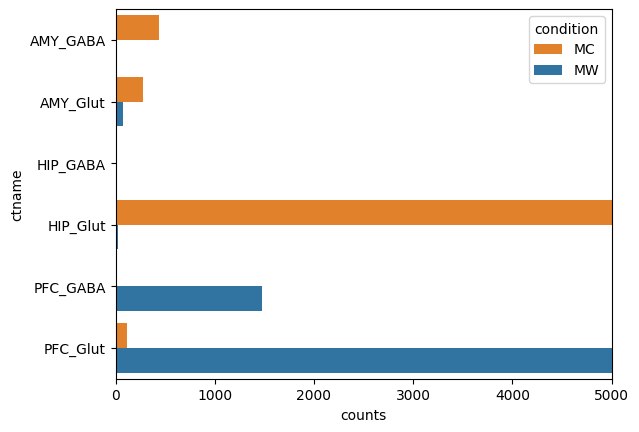

In [38]:
sns.barplot(data=df_counts, y='ctname', x='counts', hue='condition', palette=['#FF7F0E','#1F77B4'], dodge=True,ci=None)
plt.xlim(0, 5000)

/tmp/ipykernel_1037816/3047026108.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(x="condition",y='counts', hue="condition",estimator='sum',ci=None, col="region",order=['MW','MC'],hue_order=['MC','MW'], data=df_counts, kind="bar", height=4, aspect=1.5,sharey=False)


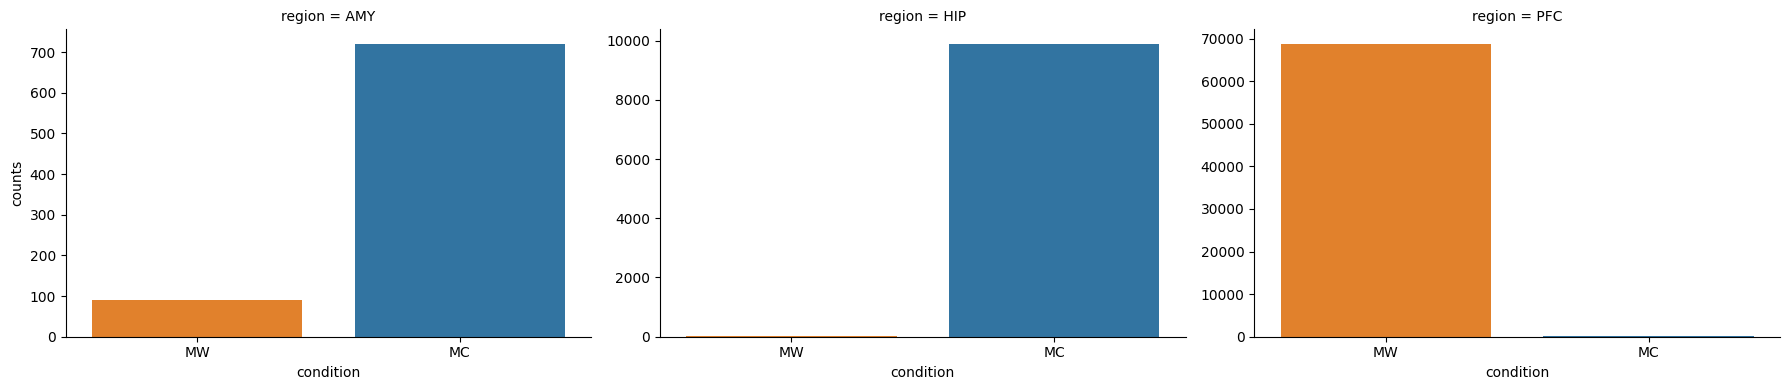

In [39]:
sns.catplot(x="condition",y='counts', hue="condition",estimator='sum',ci=None, col="region",order=['MW','MC'],hue_order=['MC','MW'], data=df_counts, kind="bar", height=4, aspect=1.5,sharey=False)

In [40]:
folder_me = '/data2st1/junyi/output/atac0416/dar/celltype.L2/'
df_DAR_mememto_l2 = pd.concat([
    merge_region(region='PFC',condition="MC",method='mementob',folder=folder_me),
    merge_region(region='PFC',condition="MW", method='mementob',folder=folder_me),
    merge_region(region='HIP',condition="MC",method='mementob',folder=folder_me),
    merge_region(region='HIP',condition="MW", method='mementob',folder=folder_me),
    merge_region(region='AMY',condition="MC",method='mementob',folder=folder_me),
    merge_region(region='AMY',condition="MW", method='mementob',folder=folder_me),
], axis=0, ignore_index=True)


In [41]:
folder_me = '/data2st1/junyi/output/atac0416/dar/celltype.L2/'
df_DAR_wicoxon_l2 = pd.concat([
    merge_region(region='PFC',condition="MC",method='wilcoxon',folder=folder_me),
    merge_region(region='PFC',condition="MW", method='wilcoxon',folder=folder_me),
    merge_region(region='HIP',condition="MC",method='wilcoxon',folder=folder_me),
    merge_region(region='HIP',condition="MW", method='wilcoxon',folder=folder_me),
    merge_region(region='AMY',condition="MC",method='wilcoxon',folder=folder_me),
    merge_region(region='AMY',condition="MW", method='wilcoxon',folder=folder_me),
], axis=0, ignore_index=True)


(0.0, 5000.0)

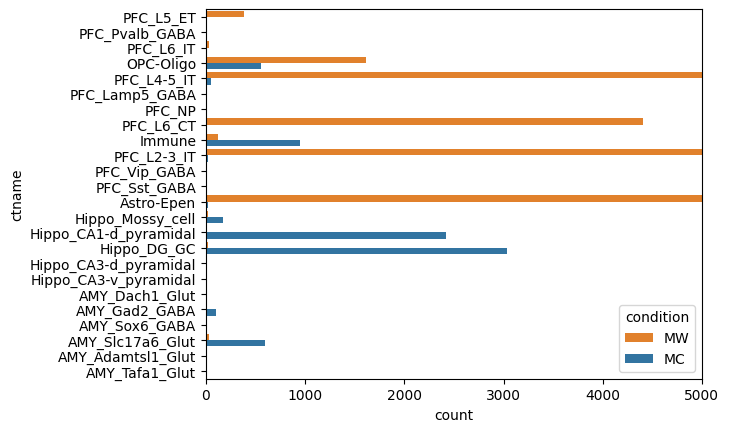

In [42]:
sns.countplot(data=df_DAR_wicoxon_l2, y='ctname', hue='condition', palette=['#FF7F0E','#1F77B4'],hue_order=['MW','MC'])
plt.xlim(0, 5000)

<Axes: xlabel='count', ylabel='ctname'>

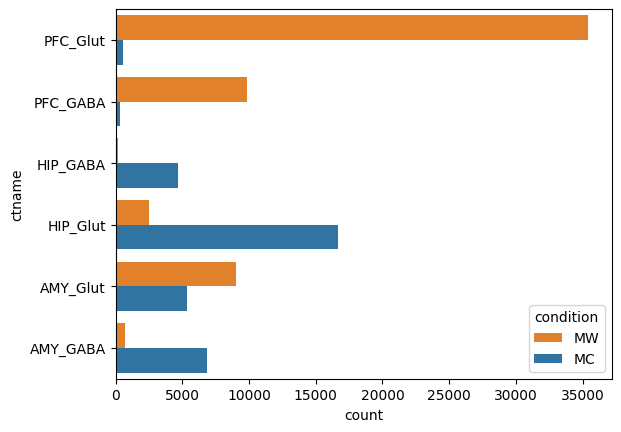

In [43]:
sns.countplot(data=df_DAR_mememto, y='ctname', hue='condition', palette=['#FF7F0E','#1F77B4'],hue_order=['MW','MC'])

(0.0, 5000.0)

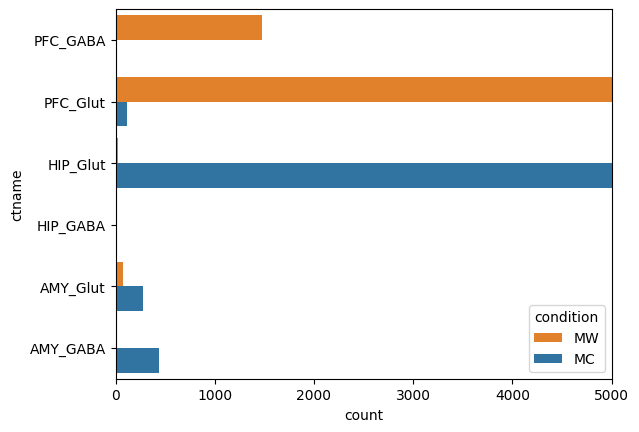

In [44]:
sns.countplot(data=df_DAR_ALL, y='ctname', hue='condition', palette=['#FF7F0E','#1F77B4'],hue_order=['MW','MC'])
plt.xlim(0, 5000)

<Axes: xlabel='count', ylabel='ctname'>

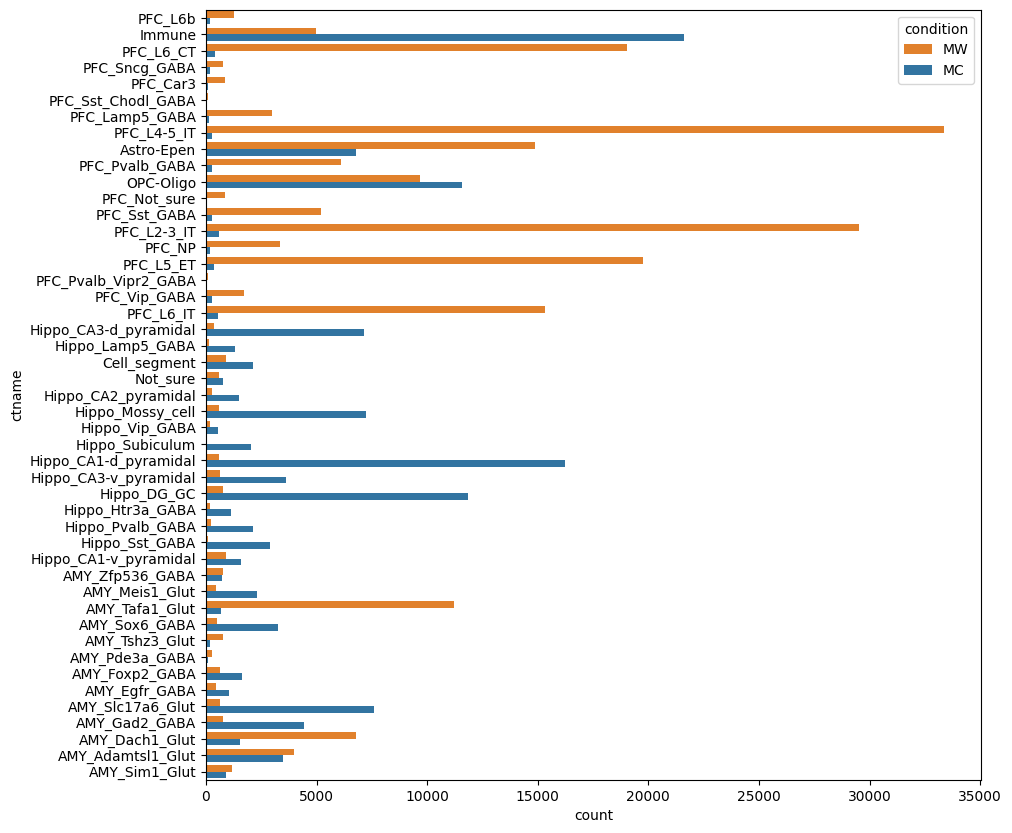

In [45]:
plt.figure(figsize=(10, 10))
sns.countplot(data=df_DAR_mememto_l2, y='ctname', hue='condition', palette=['#FF7F0E','#1F77B4'],hue_order=['MW','MC'])

In [46]:
df_DAR_mememto

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition
0,chr15:75086569-75087070,stim,0.432872,0.021699,1.011588e-88,-0.299096,0.125762,1.999109e-02,PFC_Glut,PFC,MC
1,chr12:120028551-120029052,stim,0.480524,0.024779,5.125947e-84,0.225606,0.120315,5.658753e-02,PFC_Glut,PFC,MC
2,chrX:143482812-143483313,stim,0.676692,0.040407,3.030414e-63,-0.410343,0.157938,1.027334e-02,PFC_Glut,PFC,MC
3,chr2:98662045-98662546,stim,0.504651,0.031239,5.452844e-59,-1.212180,0.093709,5.131220e-38,PFC_Glut,PFC,MC
4,chr2:98662628-98663129,stim,0.525859,0.037705,1.715753e-44,-0.758739,0.097764,1.811849e-14,PFC_Glut,PFC,MC
...,...,...,...,...,...,...,...,...,...,...,...
92126,chr8:110465569-110466070,stim,-0.112227,0.058291,4.932913e-02,0.220969,0.189618,2.729488e-01,AMY_GABA,AMY,MW
92127,chr2:29669624-29670125,stim,-0.142648,0.073045,4.936132e-02,0.079156,0.198688,6.719162e-01,AMY_GABA,AMY,MW
92128,chr16:94919198-94919699,stim,-0.121242,0.062304,4.937179e-02,0.194725,0.213193,3.660465e-01,AMY_GABA,AMY,MW
92129,chr8:105304519-105305020,stim,-0.134731,0.067952,4.939417e-02,0.467569,0.196791,1.478859e-02,AMY_GABA,AMY,MW


In [47]:
df_annotattion_mememto = utils.annotate_region(df_DAR_mememto,region_col='names', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')

In [48]:
df_annotattion_mememto

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation,distance
0,chr15:75086569-75087070,stim,0.432872,0.021699,1.011588e-88,-0.299096,0.125762,1.999109e-02,PFC_Glut,PFC,MC,Gm28502,ENSMUSG00000099452.1,75076209,75079094,-,genebody,-7476
1,chr12:120028551-120029052,stim,0.480524,0.024779,5.125947e-84,0.225606,0.120315,5.658753e-02,PFC_Glut,PFC,MC,Tmem196,ENSMUSG00000048004.15,119945821,120021246,+,genebody,-7306
2,chrX:143482812-143483313,stim,0.676692,0.040407,3.030414e-63,-0.410343,0.157938,1.027334e-02,PFC_Glut,PFC,MC,Pak3,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278
3,chr2:98662045-98662546,stim,0.504651,0.031239,5.452844e-59,-1.212180,0.093709,5.131220e-38,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0
4,chr2:98662628-98663129,stim,0.525859,0.037705,1.715753e-44,-0.758739,0.097764,1.811849e-14,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92126,chr8:110465569-110466070,stim,-0.112227,0.058291,4.932913e-02,0.220969,0.189618,2.729488e-01,AMY_GABA,AMY,MW,Hydin,ENSMUSG00000059854.8,110266976,110610253,+,genebody,0
92127,chr2:29669624-29670125,stim,-0.142648,0.073045,4.936132e-02,0.079156,0.198688,6.719162e-01,AMY_GABA,AMY,MW,Rapgef1,ENSMUSG00000039844.20,29619719,29740978,+,genebody,0
92128,chr16:94919198-94919699,stim,-0.121242,0.062304,4.937179e-02,0.194725,0.213193,3.660465e-01,AMY_GABA,AMY,MW,Kcnj6,ENSMUSG00000043301.16,94748635,94997701,-,genebody,0
92129,chr8:105304519-105305020,stim,-0.134731,0.067952,4.939417e-02,0.467569,0.196791,1.478859e-02,AMY_GABA,AMY,MW,E2f4,ENSMUSG00000014859.9,105297662,105305370,+,genebody,0


In [49]:
from statsmodels.stats.multitest import multipletests
rejected, adjusted_pvals, _, _ = multipletests(df_DAR_mememto.de_pval, method='fdr_bh')


In [50]:
df_annotattion_mememto['de_pval_adj'] = adjusted_pvals

In [51]:
df_annotattion_mememto

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation,distance,de_pval_adj
0,chr15:75086569-75087070,stim,0.432872,0.021699,1.011588e-88,-0.299096,0.125762,1.999109e-02,PFC_Glut,PFC,MC,Gm28502,ENSMUSG00000099452.1,75076209,75079094,-,genebody,-7476,9.510063e-86
1,chr12:120028551-120029052,stim,0.480524,0.024779,5.125947e-84,0.225606,0.120315,5.658753e-02,PFC_Glut,PFC,MC,Tmem196,ENSMUSG00000048004.15,119945821,120021246,+,genebody,-7306,3.234648e-81
2,chrX:143482812-143483313,stim,0.676692,0.040407,3.030414e-63,-0.410343,0.157938,1.027334e-02,PFC_Glut,PFC,MC,Pak3,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278,4.431668e-61
3,chr2:98662045-98662546,stim,0.504651,0.031239,5.452844e-59,-1.212180,0.093709,5.131220e-38,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,6.164123e-57
4,chr2:98662628-98663129,stim,0.525859,0.037705,1.715753e-44,-0.758739,0.097764,1.811849e-14,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,7.114042e-43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92126,chr8:110465569-110466070,stim,-0.112227,0.058291,4.932913e-02,0.220969,0.189618,2.729488e-01,AMY_GABA,AMY,MW,Hydin,ENSMUSG00000059854.8,110266976,110610253,+,genebody,0,4.945411e-02
92127,chr2:29669624-29670125,stim,-0.142648,0.073045,4.936132e-02,0.079156,0.198688,6.719162e-01,AMY_GABA,AMY,MW,Rapgef1,ENSMUSG00000039844.20,29619719,29740978,+,genebody,0,4.947963e-02
92128,chr16:94919198-94919699,stim,-0.121242,0.062304,4.937179e-02,0.194725,0.213193,3.660465e-01,AMY_GABA,AMY,MW,Kcnj6,ENSMUSG00000043301.16,94748635,94997701,-,genebody,0,4.948458e-02
92129,chr8:105304519-105305020,stim,-0.134731,0.067952,4.939417e-02,0.467569,0.196791,1.478859e-02,AMY_GABA,AMY,MW,E2f4,ENSMUSG00000014859.9,105297662,105305370,+,genebody,0,4.950109e-02


In [52]:
df_annotattion_mememto.loc[df_annotattion_mememto['de_pval_adj'] < 0.05]

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation,distance,de_pval_adj
0,chr15:75086569-75087070,stim,0.432872,0.021699,1.011588e-88,-0.299096,0.125762,1.999109e-02,PFC_Glut,PFC,MC,Gm28502,ENSMUSG00000099452.1,75076209,75079094,-,genebody,-7476,9.510063e-86
1,chr12:120028551-120029052,stim,0.480524,0.024779,5.125947e-84,0.225606,0.120315,5.658753e-02,PFC_Glut,PFC,MC,Tmem196,ENSMUSG00000048004.15,119945821,120021246,+,genebody,-7306,3.234648e-81
2,chrX:143482812-143483313,stim,0.676692,0.040407,3.030414e-63,-0.410343,0.157938,1.027334e-02,PFC_Glut,PFC,MC,Pak3,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278,4.431668e-61
3,chr2:98662045-98662546,stim,0.504651,0.031239,5.452844e-59,-1.212180,0.093709,5.131220e-38,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,6.164123e-57
4,chr2:98662628-98663129,stim,0.525859,0.037705,1.715753e-44,-0.758739,0.097764,1.811849e-14,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,7.114042e-43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92126,chr8:110465569-110466070,stim,-0.112227,0.058291,4.932913e-02,0.220969,0.189618,2.729488e-01,AMY_GABA,AMY,MW,Hydin,ENSMUSG00000059854.8,110266976,110610253,+,genebody,0,4.945411e-02
92127,chr2:29669624-29670125,stim,-0.142648,0.073045,4.936132e-02,0.079156,0.198688,6.719162e-01,AMY_GABA,AMY,MW,Rapgef1,ENSMUSG00000039844.20,29619719,29740978,+,genebody,0,4.947963e-02
92128,chr16:94919198-94919699,stim,-0.121242,0.062304,4.937179e-02,0.194725,0.213193,3.660465e-01,AMY_GABA,AMY,MW,Kcnj6,ENSMUSG00000043301.16,94748635,94997701,-,genebody,0,4.948458e-02
92129,chr8:105304519-105305020,stim,-0.134731,0.067952,4.939417e-02,0.467569,0.196791,1.478859e-02,AMY_GABA,AMY,MW,E2f4,ENSMUSG00000014859.9,105297662,105305370,+,genebody,0,4.950109e-02


In [53]:
#df_annotattion_mememto.to_csv(f'/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_mememto.csv',index=False)

In [54]:
annotations = [
    "/data2st1/junyi/generegion_vM23/intron_selected.bed",
    "/data2st1/junyi/generegion_vM23/exon_selected.bed",
    "/data2st1/junyi/generegion_vM23/promoter2k.bed",
    "/data2st1/junyi/generegion_vM23/repeat.bed",
    "/data2st1/junyi/generegion_vM23/cpg.bed",
    "/data2st1/junyi/generegion_vM23/UTR.bed",
    "/data2st1/junyi/generegion_vM23/CDS.bed"
]

In [55]:
df_annot = utils.annotate_region(df_DAR_mememto,region_col='names', bedfile="/data2st1/junyi/generegion_vM23/cpg.bed")

      0        1        2     3        4        5  6  7  8       9
0  chr1  3095002  3095503  chr1  3531624  3531843  .  1  6  436122
1  chr1  3120264  3120765  chr1  3531624  3531843  .  1  6  410860
Error: The closest bed file does not have the expected number of gene columns.


In [56]:
df_annot

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gstart,gend,strand,annotation,distance
0,chr15:75086569-75087070,stim,0.432872,0.021699,1.011588e-88,-0.299096,0.125762,1.999109e-02,PFC_Glut,PFC,MC,74955437,74955850,1,1,-130720
1,chr12:120028551-120029052,stim,0.480524,0.024779,5.125947e-84,0.225606,0.120315,5.658753e-02,PFC_Glut,PFC,MC,119237786,119238102,1,1,-790450
2,chrX:143482812-143483313,stim,0.676692,0.040407,3.030414e-63,-0.410343,0.157938,1.027334e-02,PFC_Glut,PFC,MC,143393869,143394250,1,9,-88563
3,chr2:98662045-98662546,stim,0.504651,0.031239,5.452844e-59,-1.212180,0.093709,5.131220e-38,PFC_Glut,PFC,MC,101678503,101678774,1,1,3015958
4,chr2:98662628-98663129,stim,0.525859,0.037705,1.715753e-44,-0.758739,0.097764,1.811849e-14,PFC_Glut,PFC,MC,101678503,101678774,1,1,3015375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92126,chr8:110465569-110466070,stim,-0.112227,0.058291,4.932913e-02,0.220969,0.189618,2.729488e-01,AMY_GABA,AMY,MW,110365437,110365643,1,7,-99927
92127,chr2:29669624-29670125,stim,-0.142648,0.073045,4.936132e-02,0.079156,0.198688,6.719162e-01,AMY_GABA,AMY,MW,29619612,29620185,1,1,-49440
92128,chr16:94919198-94919699,stim,-0.121242,0.062304,4.937179e-02,0.194725,0.213193,3.660465e-01,AMY_GABA,AMY,MW,94997408,94997830,1,1,77710
92129,chr8:105304519-105305020,stim,-0.134731,0.067952,4.939417e-02,0.467569,0.196791,1.478859e-02,AMY_GABA,AMY,MW,105297551,105297981,1,7,-6539


In [57]:
dict_annot = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        df_annot = utils.annotate_region(df_DAR_mememto,region_col='names', bedfile=file)
        dict_annot[name] = df_annot[df_annot.distance==0]
        dict_annot['cCRE'] = name
        print(f"Processed {file},{len(dict_annot[name])}")
    except:
        print(f"Error processing {file}")
        continue

Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,54154
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,44597
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,29917
      0        1        2     3        4        5         6    7  8    9
0  chr1  3095002  3095503  chr1  3095925  3095949  (TAAAA)n  216  +  423
1  chr1  3120264  3120765  chr1  3121225  3121344     MLT1A  232  -  461
Error: The closest bed file does not have the expected number of gene columns.
Processed /data2st1/junyi/generegion_vM23/repeat.bed,41429
      0        1        2     3        4        5  6  7  8       9
0  chr1  3095002  3095503  chr1  3531624  3531843  .  1  6  436122
1  chr1  3120264  3120765  chr1  3531624  3531843  .  1  6  410860
Error: The closest bed file does not have the expected number of gene columns.
Processed /data2st1/junyi/generegion_vM23/cpg.bed,34986
Processed /data2st1/junyi/generegion_vM23/UTR.bed,36048
Processed /data2st1/junyi/generegion_vM23/CDS.bed,2063

In [58]:
dict_annot['intron_selected'].names+"_"+dict_annot['intron_selected'].gene_name

3         chr2:98662045-98662546_Gm10801
4         chr2:98662628-98663129_Gm10801
5          chr6:103648949-103649450_Chl1
7          chr1:183299141-183299642_Aida
10       chr17:39845182-39845683_Gm26917
                      ...               
92126     chr8:110465569-110466070_Hydin
92127     chr2:29669624-29670125_Rapgef1
92128      chr16:94919198-94919699_Kcnj6
92129      chr8:105304519-105305020_E2f4
92130      chr17:66123319-66123820_Ddx11
Length: 54154, dtype: object

In [64]:
from upsetplot import from_contents

gene_regions = {
    'intron': set(dict_annot['intron_selected'].names+"_"+dict_annot['intron_selected'].gene_name),
    'exon': set(dict_annot['exon_selected'].names+"_"+dict_annot['exon_selected'].gene_name),
    'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),

    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)

In [65]:
gene_regions_id = gene_regions.reset_index()

In [66]:
gene_regions_id

,intron,exon,promoter,UTR,id
0,True,False,False,False,chr1:40820847-40821348_Tmem182
1,True,True,True,True,chr19:47731384-47731885_Sfr1
2,True,False,True,False,chr1:93083805-93084306_Kif1a
3,True,False,False,False,chr14:27975610-27976111_Erc2
4,True,False,False,False,chr2:5595781-5596282_Camk1d
...,...,...,...,...,...
38730,False,False,False,True,chr2:181365174-181365675_Zgpat
38731,False,False,False,True,chr7:140881634-140882135_Psmd13
38732,False,False,False,True,chr9:104262791-104263292_Dnajc13
38733,False,False,False,True,chr19:5041060-5041561_Gm50388


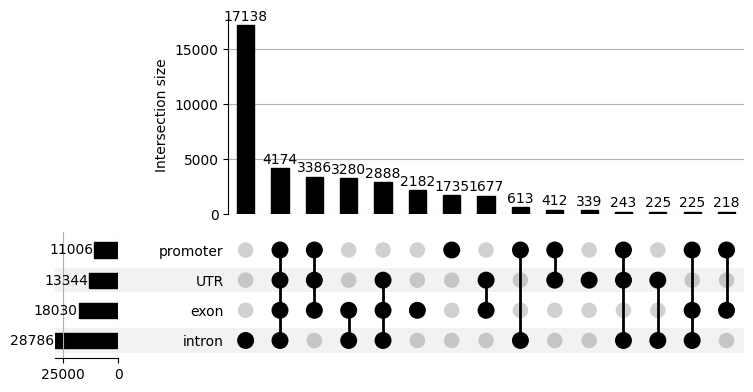

In [68]:
from upsetplot import UpSet

ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


In [ ]:
df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)

In [ ]:
df_deg_select = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M") & (df_deg.region.isin(['AMY','HIP','PFC']))]

In [ ]:
df_deg_select['condition'] = 'MW'
df_deg_select.loc[df_deg_select.de_coef>0,'condition'] = 'MC'

In [ ]:
df_deg_select.groupby

In [ ]:
df_annotattion_mememto.groupby('gene').count().mean()

In [ ]:
df_degdar = df_annotattion_mememto.merge(df_deg_select,how='inner',left_on=['ctname','condition','gene'],right_on=['ctname','condition','gene'],suffixes=('_atac', '_sc'))

In [ ]:
df_degdar.corr(method='pearson')

In [ ]:
sns.countplot(data=df_degdar, y='ctname', hue='condition', palette=['#FF7F0E','#1F77B4'],hue_order=['MW','MC'])


In [ ]:
df_degdar['coefsq'] = df_degdar['de_coef_atac']*df_degdar['de_coef_sc']

In [ ]:
df_degdar.sort_values(by=['coefsq']).to_csv('/data2st1/junyi/output/atac0416/dar/region_nt/df_degdar.csv',index=False)

In [ ]:
out_dir ='/data2st1/junyi/output/atac0416/dar/motif/region_nt'
for ct in df_inner['ctname'].unique():
    for condition in df_inner['condition'].unique():
        df_sub = df_inner[(df_inner['ctname'] == ct) & (df_inner['condition'] == condition)]
        if len(df_sub) == 0:
            continue
        df_sub["names"].str.split(r'[:-]', expand=True).to_csv(f'{out_dir}/{ct}_{condition}_inner.bed', sep='\t', header=False, index=False)


In [ ]:
files = glob.glob('/data2st1/junyi/output/atac0416/dar/motif/region_nt/*_inner.bed')
for filename in files:
    command_str = ['pycistarget','cistarget','--cistarget_db_fname','/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather'
                   ,'--bed_fname',filename,'--species','mus_musculus','--auc_threshold','0.005','--nes_threshold','3.0','--rank_threshold','0.05'
                   ,'--path_to_motif_annotations','/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl'
                   ,'--output_folder','/data2st1/junyi/output/atac0416/dar/motif/region_nt/','--write_html']
    print(command_str)
    subprocess.run(command_str)

In [ ]:
ax = sns.countplot(data=df_inner, x='ctname', hue='condition', dodge=False, palette='Set2',)
plt.ylim(0, 5000)


In [ ]:
for ct in df_inner['ctname'].unique():
    for condition in df_inner['condition'].unique():
        try:
            flist = glob.glob(f'/data2st1/junyi/output/atac0416/dar/motif/region_nt/*{ct}*{condition}*_inner.hdf5')
            df_report = utils.conclude_pycistargets(flist)  
            df_report_annotation = utils.annotate_region(df_report,region_col='region', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')
            df_report_annotation.to_csv(f'/data2st1/junyi/output/atac0416/dar/motif/region_nt/{ct}_{condition}_inner_region_TF.csv', index=False)
        except Exception as e:
            print(f"Error processing {ct} and {condition}: {e}")


In [ ]:
df_report_annotation

In [ ]:
df_report_annotation.to_csv('/data2st1/junyi/output/atac0416/dar/motif/region_nt/AMT_MC.csv',index=False)

In [ ]:
for filename in files:
    df_dar  = pd.read_csv(filename,index_col=0)
    experimentname = re.split(r'[./]', filename)[-2]
    experimentname
    folder_name = os.path.dirname(filename)
    df_dar_filtered = df_dar[(df_dar['pvals']<0.05) & (df_dar['logfoldchanges']>0) ]
    df_dar_filtered.sort_values(by='logfoldchanges',ascending=False,inplace=True)
    # For liftover

    temp_df = df_dar_filtered.names.str.split(r'[ ,!\-;:|]',expand=True)
    temp_df['ID'] = temp_df.index
    temp_df.to_csv(f"{folder_name}/{experimentname}_DAR.bed",header=False,index=False,sep="\t")

In [ ]:
# import subprocess
# files = glob.glob('/data2st1/junyi/output/motif/ALL_*_wilcoxon_DAR.bed')
# for filename in files:
#     experimentname = re.split(r'[./]', filename)[-2]
#     folder_name = os.path.dirname(filename)

#     #!/home/junyichen/liftOver /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_unmap.bed

#     command_str = f"/home/junyichen/liftOver {filename} /data2st1/junyi/mm39ToMm10.over.chain.gz {folder_name}/{experimentname}_lifted.bed {folder_name}/{experimentname}_unmap.bed"
#     print(command_str)
#     subprocess.run(command_str, shell=True)

In [ ]:
import subprocess

In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/ALL_*_wilcoxon_DAR_lifted.bed')
for filename in files:
    destname = filename.replace("_lifted.bed","_lifted_sorted.bed")
    #!sort -k1,1 -k2,2n {filename} > {destname}
    command_str = f"sort -k1,1 -k2,2n {filename} > {destname}"
    print(command_str)
    subprocess.run(command_str, shell=True)

In [ ]:
# !sort -k1,1 -k2,2n /data2st1/junyi/output/motif/HIP_Neuron_MC_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/HIP_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed

In [ ]:
# !sort -k1,1 -k2,2n /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed

In [ ]:
# !bedtools closest -a /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_gene.bed

In [ ]:
# !bedtools closest -a /data2st1/junyi/output/motif/HIP_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/HIP_Neuron_MC_wilcoxon_DAR_gene.bed

In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/ALL_*_wilcoxon_DAR_lifted.bed')
for filename in files:
    command_str = ['pycistarget','cistarget','--cistarget_db_fname','/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather'
                   ,'--bed_fname',filename,'--species','mus_musculus','--auc_threshold','0.005','--nes_threshold','3.0','--rank_threshold','0.05'
                   ,'--path_to_motif_annotations','/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl'
                   ,'--output_folder','/data2st1/junyi/output/motif/','--write_html']
    print(command_str)
    subprocess.run(command_str)
    
# !pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
# --bed_fname '/data2st1/junyi/output/motif/AMY_Neuron_MC_wilcoxon_DAR_lifted.bed' \
# --species 'mus_musculus' \
# --auc_threshold 0.005 \
# --nes_threshold 3.0 \
# --rank_threshold 0.05 \
# --path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
# --output_folder '/data2st1/junyi/output/motif/' \
# --write_html 

In [ ]:
import h5py
dict_table = {}
cell_types = ['Neuron','Astro-Epen','Vascular','Immune','OPC-Oligo']
for celltype in cell_types:
    with h5py.File(f'/data2st1/junyi/output/motif/motif_enrichment_cistarget_ALL_{celltype}_wilcoxon_DAR_lifted.hdf5', 'r') as f:
        # Open the HDF5 file
        # List all groups and datasets in the file
        print("Keys in the file:", list(f.keys()))
        

        # # Access a specific dataset
        expname = f'ALL_{celltype}_wilcoxon_DAR_lifted'
        dataset = f[expname]  # Replace with your dataset name
        # print("Shape of the dataset:", dataset.shape)
        # print("Data type of the dataset:", dataset.dtype)
        dict_dataset = {}
        #region = f[expname]['motif_hits']['region_set']['metacluster_33.8'][0:10]

        table = f[expname]['motif_enrichment']['table'][:]
        for key in dataset.keys():
            dict_dataset[key] = dataset[key]
        # print("Data:", data)
        dict_table[expname] = table

In [ ]:
for keys in dict_table.keys():
    print(keys)
    print(dict_table[keys][:5])
    #Astro : id, orthology, direcrt, id, msimilarity,logo
    #Neuron : id,logo,orthology, id, direct, msimilarity
    #Vascular : id,logo,orthology,msimilarity,id, direct

In [ ]:
list_table = []
list_key = []
list_TFs = []

df_TF_celltype = pd.DataFrame()

for key in dict_table.keys():
    data = dict_table[key]
    for row in data:
        list_table.append(row[0].decode('utf-8'))
        list_key.append(key)
        TFs_tmp=[]
        for i in range(1, len(row)-2):
            if 'img' in row[i][0].decode('utf-8') or 'wilcoxon' in row[i][0].decode('utf-8'):
                continue
            TFs_tmp+=([ tf.decode('utf-8') for tf in row[i]])

        df_tfs = pd.DataFrame({'TF':",".join(TFs_tmp).split(',')})
        df_tfs['NES'] = row[-2][0]
        df_tfs['AUC'] = row[-2][1]
        df_tfs['Rank'] = row[-2][2]
        df_tfs['celltype.L1'] = key.split('_')[1]
        df_tfs['id'] = row[0].decode('utf-8')

        list_TFs.append(set(TFs_tmp))
        df_TF_celltype = pd.concat([df_TF_celltype,df_tfs],axis=0)
        
df_TF = pd.DataFrame({'TF':list_table,'key':list_key,'TFs':list_TFs})

In [ ]:
df_TF_celltype.drop_duplicates(inplace=True)


In [ ]:
df_TF_celltype

In [ ]:
df_RSS = pd.read_csv("/home/junyichen/code/scmmd/data/RSS_Score(only pos).csv",index_col=0)

In [ ]:
df_RSS['TF']=df_RSS['Topic'].str.replace('[()+]','')

In [ ]:
cell_to_category = {
    # Astro-Epen
    'Astro-Gfaphigh': 'Astro-Epen',
    'Astro-TE': 'Astro-Epen',
    
    # Immune
    'Microglia': 'Immune',
    'PVM': 'Immune',
    
    # Neuron
    'L2/3 IT': 'Neuron',
    'L4/5 IT': 'Neuron',
    'L5 ET': 'Neuron',
    'L6 CT': 'Neuron',
    'L6 IT': 'Neuron',
    'L6b': 'Neuron',
    'Lamp5 GABA': 'Neuron',
    'Pvalb GABA': 'Neuron',
    'Pvalb Vipr2 GABA': 'Neuron',
    'Sst GABA': 'Neuron',
    'Vip GABA': 'Neuron',
    
    # OPC-Oligo
    'COP': 'OPC-Oligo',
    'MFOL': 'OPC-Oligo',
    'MOL': 'OPC-Oligo',
    'NFOL': 'OPC-Oligo',
    'NP': 'OPC-Oligo',
    'OPC': 'OPC-Oligo',
    
    # Vascular
    'Arachnoid barrier cell': 'Vascular',
    'Car3': 'Vascular',
    'Endothelial cell': 'Vascular',
    'Pericyte': 'Vascular',
    'VLMC': 'Vascular'
}

In [ ]:
df_RSS['celltype.L1'] = df_RSS['celltype.L2'].map(cell_to_category)


In [ ]:
df_TF_celltype.groupby(['celltype.L1']).nunique()

In [ ]:
df_RSS.groupby(['celltype.L1']).nunique()

In [ ]:
df_merged = df_RSS.merge(df_TF_celltype,left_on=['TF','celltype.L1'],right_on=['TF','celltype.L1'],how='inner')

In [ ]:
df_merged.sort_values(by='RSS',ascending=False,inplace=True)

In [ ]:
df_merged.drop_duplicates(set(['TF','celltype.L1']),keep='first').to_csv('/data2st1/junyi/output/motif/TF_RSS.csv',index=False)

In [ ]:
df_merged.groupby('celltype.L1').nunique()

In [ ]:
ct = pd.crosstab(df_merged['celltype'],df_merged['celltype.L1'],values=df_merged['RSS'],aggfunc='count')

In [ ]:
ct

In [ ]:
set(df_merged['celltype']
)

In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/ALL_*_wilcoxon_DAR_lifted_sorted.bed')
for filename in files:
    destname = filename.replace("_lifted_sorted.bed","_lifted_sorted_gene.bed")
    command_str = f"bedtools closest -a {filename} -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > {destname}"
    print(command_str)
    subprocess.run(command_str, shell=True)
# !bedtools closest -a /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_gene.bed

In [ ]:
!pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
--bed_fname '/data2st1/junyi/output/motif/AMY_Neuron_MC_wilcoxon_DAR_lifted.bed' \
--species 'mus_musculus' \
--auc_threshold 0.005 \
--nes_threshold 3.0 \
--rank_threshold 0.05 \
--path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
--output_folder '/data2st1/junyi/output/motif/' \
--write_html 

In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon.csv')
for filename in files:
    df_dar  = pd.read_csv(filename,index_col=0)
    experimentname = re.split(r'[./]', filename)[-2]
    experimentname
    folder_name = os.path.dirname(filename)
    df_dar_filtered = df_dar[(df_dar['pvals']<0.05) & (df_dar['logfoldchanges']>0) ]
    df_dar_filtered.sort_values(by='logfoldchanges',ascending=False,inplace=True)
    # For liftover
    df_dar_filtered.names.str.split(r'[ ,!\-;:|]',expand=True).to_csv(f"{folder_name}/{experimentname}_DAR.bed",header=False,index=False,sep="\t")

In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon_DAR.bed')
for filename in files:
    experimentname = re.split(r'[./]', filename)[-2]
    folder_name = os.path.dirname(filename)

    #!/home/junyichen/liftOver /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_unmap.bed

    command_str = f"/home/junyichen/liftOver {filename} /data2st1/junyi/mm39ToMm10.over.chain.gz {folder_name}/{experimentname}_lifted.bed {folder_name}/{experimentname}_unmap.bed"
    print(command_str)
    subprocess.run(command_str, shell=True)

In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon_DAR_lifted.bed')
for filename in files:
    destname = filename.replace("_lifted.bed","_lifted_sorted.bed")
    #!sort -k1,1 -k2,2n {filename} > {destname}
    command_str = f"sort -k1,1 -k2,2n {filename} > {destname}"
    print(command_str)
    subprocess.run(command_str, shell=True)
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon_DAR_lifted_sorted.bed')
for filename in files:
    destname = filename.replace("_lifted_sorted.bed","_lifted_sorted_gene.bed")
    command_str = f"bedtools closest -a {filename} -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > {destname}"
    print(command_str)
    subprocess.run(command_str, shell=True)

In [ ]:
# from pyliftover import LiftOver
# lo = LiftOver('/data2st1/junyi/mm10ToMm39.over.chain.gz')
# lo.convert_coordinate('chr1', 1000000, '-')


In [ ]:
result_frame = pd.DataFrame()
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon_DAR_lifted_sorted_gene.bed')
for filename in files:
    experimentname = re.split(r'[./]', filename)[-2]
    region = re.split(r'_',experimentname)[0]
    celltype = re.split(r'_',experimentname)[1]
    condition = re.split(r'_',experimentname)[2]
    try:
        df = pd.read_csv(filename,sep='\t',header=None)
    except:
        continue
    df.columns = ['chrom','start','end','chrom2','start2','end2','score','starnd','gene_name','gene_id','annotation','distance']
    df['region'] = region
    df['celltype'] = celltype
    df['condition'] = condition
    df['name'] = df['chrom'] + ':' + df['start'].astype(str) + '-' + df['end'].astype(str)
    # df_score = pd.read_csv(f"/data2st1/junyi/output/motif/{region}_{celltype}_{condition}_wilcoxon.csv",index_col=0)
    # df['logfoldchanges'] = df_score.set_index('names').loc[df['name'],'logfoldchanges'].values
    # df['pvals'] = df_score.set_index('names').loc[df['name'],'pvals'].values
    result_frame = pd.concat([result_frame,df])

In [ ]:
ax = sns.countplot(data=result_frame, x='celltype', hue='region', dodge=False, palette='Set2',)
ax.set_ylim(0,6000)


In [ ]:
keep1=result_frame.sort_values(by='starnd',ascending=True).drop_duplicates(subset=['chrom','start','end'])
keep1['generegion'] = 'genebody'
#keep1.loc[keep1['distance']<0,'generegion'] = 'downstream'
promoter = keep1.loc[(keep1['distance']>0) & (keep1['distance']<=2000) & (keep1['starnd']=='+')].index
distal = keep1.loc[(keep1['distance']>0) & (keep1['distance']>=2000) & (keep1['starnd']=='+')].index
keep1.loc[promoter,'generegion'] = 'promoter'
keep1.loc[distal,'generegion'] = 'distal'

promoter = keep1.loc[(keep1['distance']<0) & (keep1['distance']>=-2000) & (keep1['starnd']=='-')].index
distal = keep1.loc[(keep1['distance']<0) & (keep1['distance']<=-2000) & (keep1['starnd']=='-')].index
keep1.loc[promoter,'generegion'] = 'promoter'
keep1.loc[distal,'generegion'] = 'distal'


In [ ]:
keep1=keep1.loc[keep1['start2']>0]

In [ ]:
keep1.sort_values(by='starnd',ascending=True).drop_duplicates(subset=['chrom','start','end'])

In [ ]:
ax = sns.countplot(data=keep1, x='celltype', hue='generegion', dodge=False, palette='Set2',)

In [ ]:
pd.read_csv('/data2st1/junyi/output/motif/AMY_Neuron_MC_wilcoxon.csv',index_col=0)

In [ ]:
# Convert hg38 to hg19
# !/home/junyichen/liftOver /data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR_unmap.bed
# !/home/junyichen/liftOver /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_unmap.bed
# !/home/junyichen/liftOver /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR_unmap.bed


In [ ]:
!pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
--bed_fname '/data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR_lifted.bed' \
--species 'mus_musculus' \
--auc_threshold 0.005 \
--nes_threshold 3.0 \
--rank_threshold 0.05 \
--path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
--output_folder '/data2st1/junyi/output/motif/' \
--write_html

In [ ]:
!pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
--bed_fname '/data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR_lifted.bed' \
--species 'mus_musculus' \
--auc_threshold 0.005 \
--nes_threshold 3.0 \
--rank_threshold 0.05 \
--path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
--output_folder '/data2st1/junyi/output/motif/' \
--write_html

In [ ]:
!pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
--bed_fname '/data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_lifted.bed' \
--species 'mus_musculus' \
--auc_threshold 0.005 \
--nes_threshold 3.0 \
--rank_threshold 0.05 \
--path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
--output_folder '/data2st1/junyi/output/motif/' \
--write_html

In [ ]:
import h5py
import copy

regions = ['AMY','HIP','PFC']
celltypes = ['Neuron']

dict_table = {}

for region in regions:
    for celltype in celltypes:
        with h5py.File(f'/data2st1/junyi/output/motif/motif_enrichment_cistarget_{region}_{celltype}_MC_wilcoxon_DAR_lifted.hdf5', 'r') as f:
            # Open the HDF5 file
            # List all groups and datasets in the file
            print("Keys in the file:", list(f.keys()))
            

            # # Access a specific dataset
            expname = f'{region}_{celltype}_MC_wilcoxon_DAR_lifted'
            dataset = f[expname]  # Replace with your dataset name
            # print("Shape of the dataset:", dataset.shape)
            # print("Data type of the dataset:", dataset.dtype)

            dict_dataset = {}

            #region = f[expname]['motif_hits']['region_set']['metacluster_33.8'][0:10]

            table = f[expname]['motif_enrichment']['table'][:]
            for key in dataset.keys():
                dict_dataset[key] = dataset[key]
            # print("Data:", data)
            dict_table[expname] = table

In [ ]:
for i in dict_table['AMY_Neuron_MC_wilcoxon_DAR_lifted']:
    print(i[0])

In [ ]:
region_table = {}

for region in regions:
    for celltype in celltypes:
        with h5py.File(f'/data2st1/junyi/output/motif/motif_enrichment_cistarget_{region}_{celltype}_MC_wilcoxon_DAR_lifted.hdf5', 'r') as f:
            # Open the HDF5 file
            # List all groups and datasets in the file
            print("Keys in the file:", list(f.keys()))
            

            # # Access a specific dataset
            expname = f'{region}_{celltype}_MC_wilcoxon_DAR_lifted'
            dataset = f[expname]  # Replace with your dataset name
            # print("Shape of the dataset:", dataset.shape)
            # print("Data type of the dataset:", dataset.dtype)

            dict_dataset = {}

            region = f[expname]['motif_hits']['region_set']['metacluster_33.8'][:]
            region_table[expname] = region

In [ ]:
import numpy as np

list_table = []
list_key = []

for key in dict_table.keys():
    data = dict_table[key]
    for row in data:
        list_table.append(row[0])
        list_key.append(key)
df_TF = pd.DataFrame({'TF':list_table,'key':list_key})

In [ ]:
df_TF

In [ ]:
df_count = df_TF.groupby('TF').count().sort_values(by='key',ascending=False)

In [ ]:
df_count[df_count['key']>2].index

In [ ]:
df_regions = pd.DataFrame()

for region in regions:
    for celltype in celltypes:
        with h5py.File(f'/data2st1/junyi/output/motif/motif_enrichment_cistarget_{region}_{celltype}_MC_wilcoxon_DAR_lifted.hdf5', 'r') as f:
            # Open the HDF5 file
            # List all groups and datasets in the file
            print("Keys in the file:", list(f.keys()))
            

            # # Access a specific dataset
            expname = f'{region}_{celltype}_MC_wilcoxon_DAR_lifted'
            dataset = f[expname]  # Replace with your dataset name
            # print("Shape of the dataset:", dataset.shape)
            # print("Data type of the dataset:", dataset.dtype)


            for TF in df_count[df_count['key']>2].index:
                region = f[expname]['motif_hits']['region_set'][TF][:]
                decoded_data = [item.decode('utf-8') for item in region]
                df_region = pd.DataFrame(decoded_data,columns=['region'])
                df_region['expreiment'] = expname
                df_region['TF'] = TF.decode('utf-8')
                if len(df_regions)>0:
                    df_regions = pd.concat([df_regions,df_region],axis=0,ignore_index=True)
                else:
                    df_regions = df_region
            #region = f[expname]['motif_hits']['region_set']['metacluster_33.8'][:]
            #region_table[expname] = df_regions

In [ ]:
df_count[df_count['key']>2].index

In [ ]:
df_regions.head(10)

In [ ]:
region_table

In [ ]:
sns.countplot(data=df_TF, x='key', dodge=False, palette='Set2',)
plt.xticks(rotation=60)


In [ ]:
for key in dict_table.keys():
    print(len(dict_table[key]))

In [ ]:
table